# Strain mapping of simulated Ge/SiGe multilayer stacks

This notebook measures the strain fields of a simulated 4D-STEM dataset  which consists of alternating $Si / Si_{50}Ge_{50}$ multilayer stacks, on a $Si_{25}Ge_{75}$ substrate, using correlation based approach in py4DSTEM.  This notebook uses the "distorted" simulation, where the sample is has  been  tilted  off  the  ideal diffraction  condition.

[Download the simulated Si/SiGe multilayer dataset with an distorted structure, after it has been cropped and downsampled.](https://drive.google.com/file/d/12aCef_a5XTbOr17H3YF9aRAsf5jo0mtt/view?usp=sharing)

### Simulation Parameters

|Parameter | Value | Units |
|:--- |:--- |:--- |
| accelerating voltage | 200 | kV |
| wavelength | 0.02508 | Ang |
| convergence semiangle | 2 | mrads |
| cell dimensions | (1008.28,   253.58,  404.14) | Ang |
| algorithm | PRISM |  |
| interpolation factors | (12, 3) |  |
| scan range x | (0.1, 0.9) | Ang |
| scan range y | (0.1, 0.9) | Ang |
| probe step x | 4.03 | Ang |
| probe step y | 4.06 | Ang |

### Acknowledgements

This tutorial was written by Ben Savitzky (bhsavitzky@lbl.gov) and Colin Ophus (clophus@lbl.gov) at Berkeley Lab.

The dataset was simulated by Alexander Rakowski (ARakowski@lbl.gov) and Colin Ophus (clophus@lbl.gov), using the [Prismatic simulation code](https://prism-em.com/), with help from Luis Rangel DaCosta (luisrd@berkeley.edu ).

### Version
Last updated on 2022-01-20 with py4DSTEM version 0.12.8.

If you are running in **binder** run the cell below, otherwise skip.

In [ ]:
from py4DSTEM.io import download_file_from_google_drive
download_file_from_google_drive("12aCef_a5XTbOr17H3YF9aRAsf5jo0mtt", "./Si_SiGe_distorted_50x200_201x50x256x256.h5"")
download_file_from_google_drive("1-tLGhJyCqMxxz5gg9_R6MfowOK5KI_hv", "./strain_profile_simulated.csv")

In [1]:
import copy
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
py4DSTEM.__version__

'0.12.8'

In [3]:
# File paths - output files will be augmented with the correct file extension
file_path_input = './Si_SiGe_distorted_50x200_201x50x256x256.h5'
file_path_output = '/global/cscratch1/sd/jmunshi/4DCrystal/CNNTrainingNetwork/datasets/strain_data/strain_outputs/Si_SiGe_distorted_analysis_corr.h5'

In [4]:
# # Import the vacuum probe and simulated 4D-STEM datacube
ideal_multilayer = h5py.File(file_path_input,'r')
probe = np.asarray(ideal_multilayer['probe'])
dataset = py4DSTEM.io.DataCube(np.asarray(ideal_multilayer['datacube']))

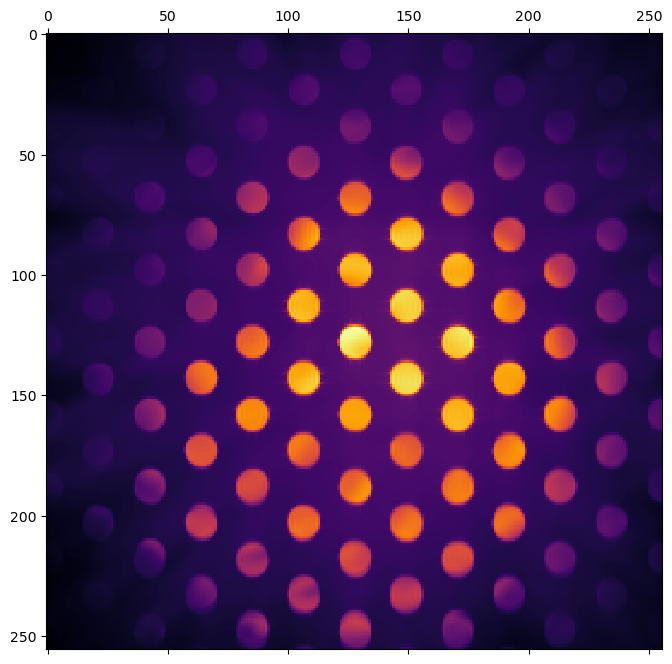

In [5]:
# Calculate the mean CBED
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))

# Plot the mean CBED
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='log',
    cmap='inferno')

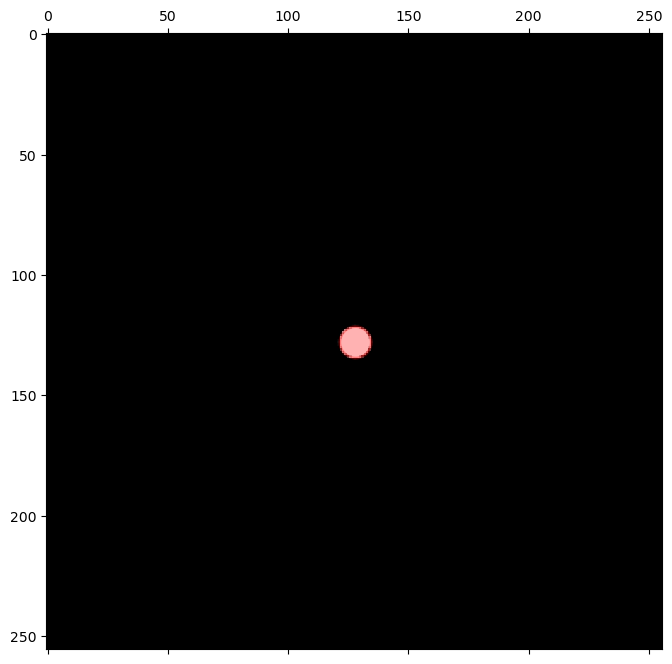

Estimated probe radius = 6.53 pixels


In [6]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    probe, thresh_lower = 0.1, thresh_upper = 0.99)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    probe, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

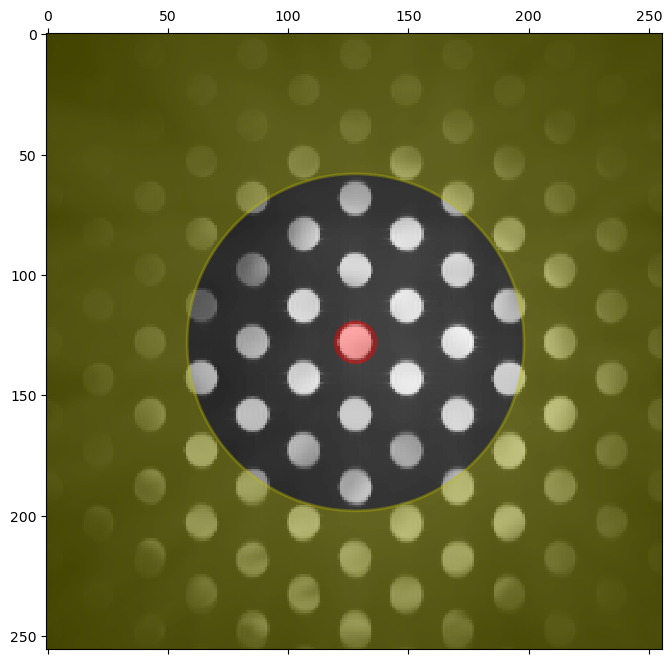

In [7]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector will be set to high scattering angles, picking up just a hint of the coherent diffraction.
expand_BF = 2.0
det_DF = (70,1000)

# Show selected virtual detectors
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='log',
    cmap='gray',
    circle={'R':probe_semiangle + expand_BF,
             'center':(qx0,qy0),
             'fill':True,
             'color':'r',
             'alpha':0.35},
    annulus={'Ri':det_DF[0],
             'Ro':det_DF[1],
             'center':(qx0,qy0),
             'fill':True,
             'color':'y',
             'alpha':0.35}
)

In [8]:
# Compute BF and DF virtual images
image_BF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset, 
    qx0, qy0, 
    det_DF[0],
    det_DF[1])

100%|██████████| 10050/10050 [00:00<00:00, 16156.21it/s]


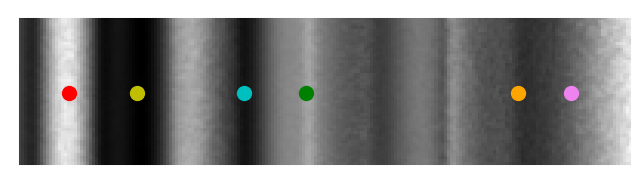

In [9]:
#Let's look at the bright field image; 
#the colored scatter plots are six random locations 
#which we will use for visualizing the Bragg disks in the next section...

rxs = 17, 39, 74, 94, 163, 180
rys = 25,25,25,25,25,25

fig, ax = py4DSTEM.visualize.show(np.transpose(image_BF),
                                  figsize=(16,2),
                                  bordercolor = 'w',
                                  cmap='gray',
                                  returnfig = True)
ax.scatter(rxs[0], rys[0], c='r', s=100)
ax.scatter(rxs[1], rys[1] , c='y', s=100)
ax.scatter(rxs[2], rys[2], c='c', s=100)
ax.scatter(rxs[3], rys[3], c='g', s=100)
ax.scatter(rxs[4], rys[4], c='orange', s=100)
ax.scatter(rxs[5], rys[5], c='violet', s=100)
#fig.savefig('./paper_figs/simulated_ideal_BF.pdf', dpi=600)
plt.show()

# Bragg disk detection

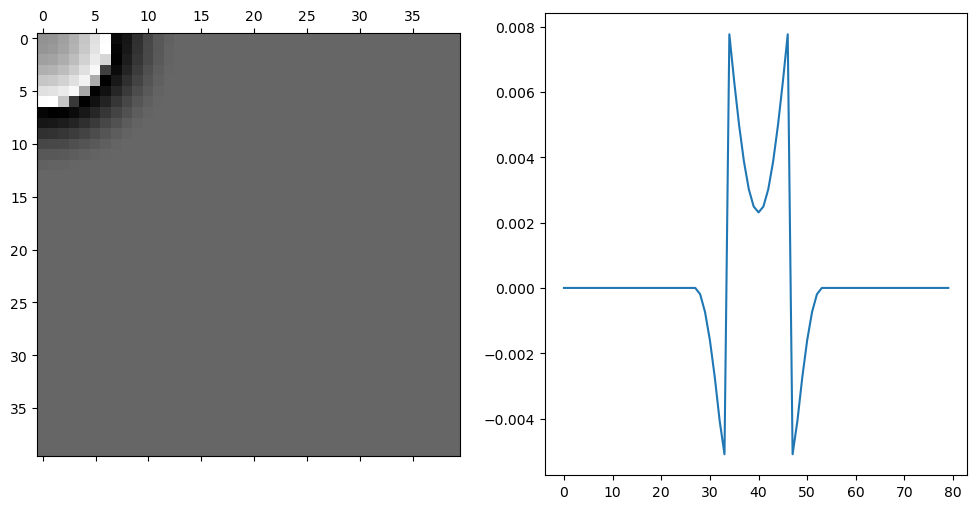

In [10]:
# Construct a probe template - we already have the probe array imported, so we start there.

# Shift probe to the origin and apply normalization by subtracting a sigmoid function.
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe.data, 
    probe_semiangle * 0.0,                                            
    probe_semiangle * 2.0,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=40, 
    L=40, 
    W=2)

In [11]:
## Test hyperparameters on a few probe positions
colors=['r','y','c','g','orange', 'violet']

dp0 = dataset.data[rxs[0],rys[0],:,:]
dp1 = dataset.data[rxs[1],rys[1],:,:]
dp2 = dataset.data[rxs[2],rys[2],:,:]
dp3 = dataset.data[rxs[3],rys[3],:,:]
dp4 = dataset.data[rxs[4],rys[4],:,:]
dp5 = dataset.data[rxs[5],rys[5],:,:]

# Run the disk detection on the selected DPs
corrPower=1.0
sigma=0
edgeBoundary= 16
minRelativeIntensity=0.001
minPeakSpacing= 24
subpixel='multicorr'
upsample_factor=32
maxNumPeaks = 200


disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

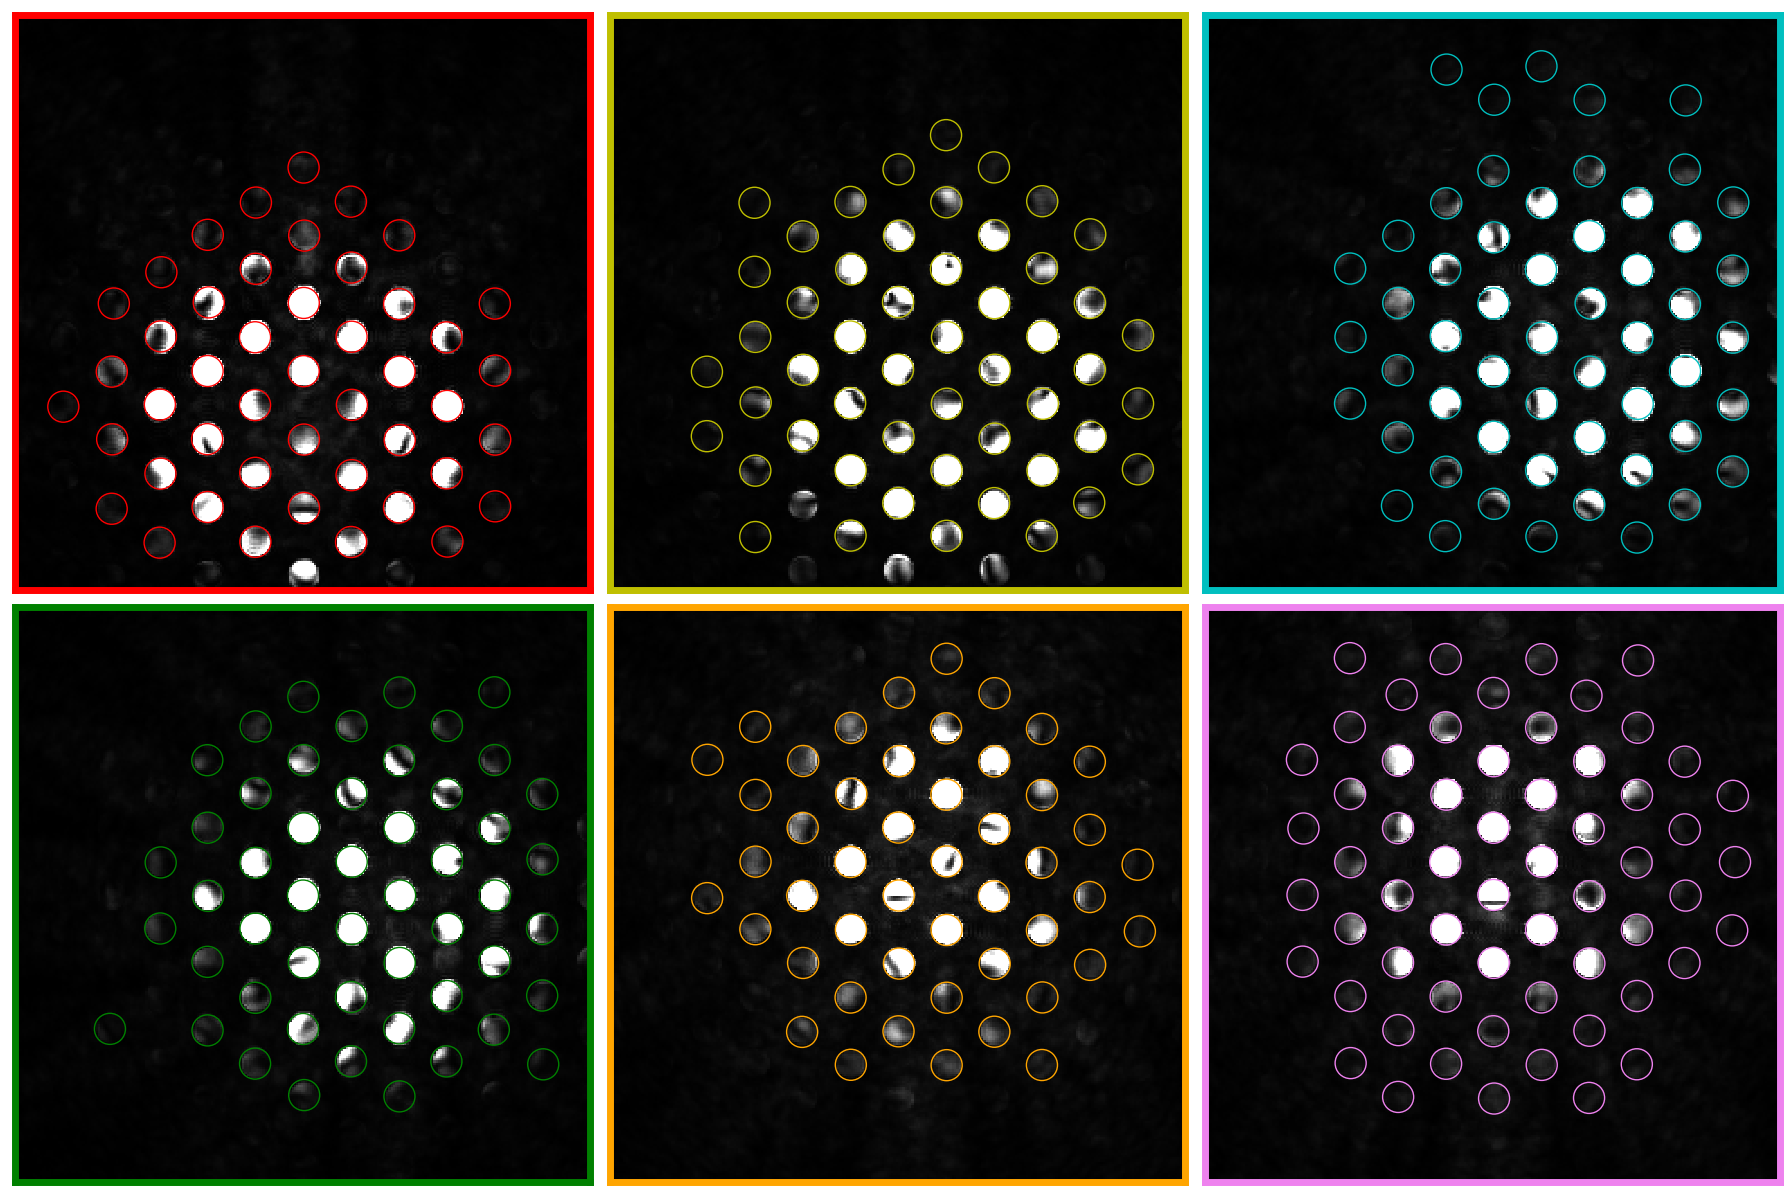

In [12]:
#Lets visualize the diffraction patterns and the located disk positions

fig, ax = py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2,dp3,dp4, dp5][i],H=2,W=3,
    axsize=(6,6),
    clipvals='manual',
    min=0.0000002,
    max=0.00005,              
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=500,
    returnfig= True)
#fig.savefig('./paper_figs/distort_DP.pdf', dpi=600)
plt.show()

In [13]:
# Here are some tuned hyperparameters that we think are fairly accurate:
# probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
#     probe.data, 
#     probe_semiangle * 0.0,                                            
#     probe_semiangle * 2.0,)
# corrPower=1.0
# sigma=0
# edgeBoundary= 16
# minRelativeIntensity=0.004
# minPeakSpacing= 24
# subpixel='poly'
# upsample_factor=4

In [14]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~1 minute for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.

bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor,
    CUDA =True
)

Finding Bragg Disks: 100%|██████████| 10.1k/10.1k [06:11<00:00, 27.1DP/s]

Analyzed 10050 diffraction patterns in 0h 6m 11s


# Fit a lattice

In [15]:
# Center the Bragg disk positions about the origin
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

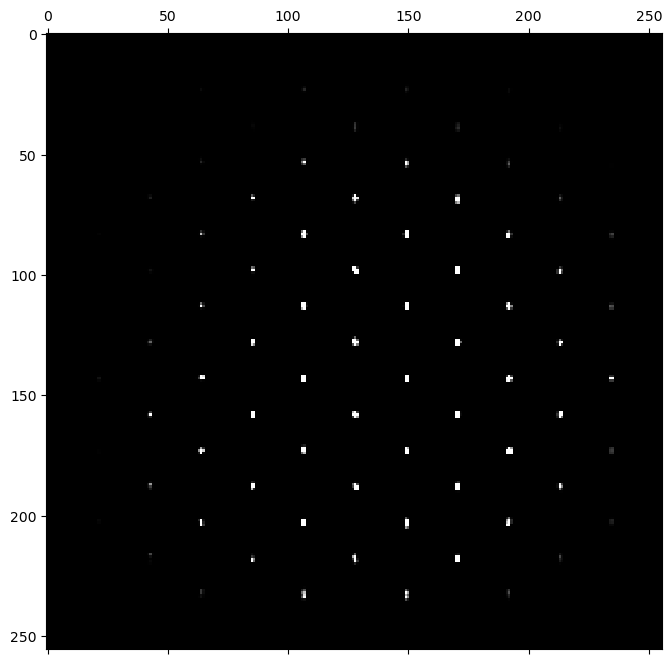

In [16]:
# Compute and plot Bragg vector map (BVM).
# A BVM is a 2D hisogram of all of the detected peak locations - we will use it to identify the crystalline lattice.

# Compute the Bragg vector map
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    dataset.Q_Nx,
    dataset.Q_Ny)

# plot the Bragg vector map
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e-2)

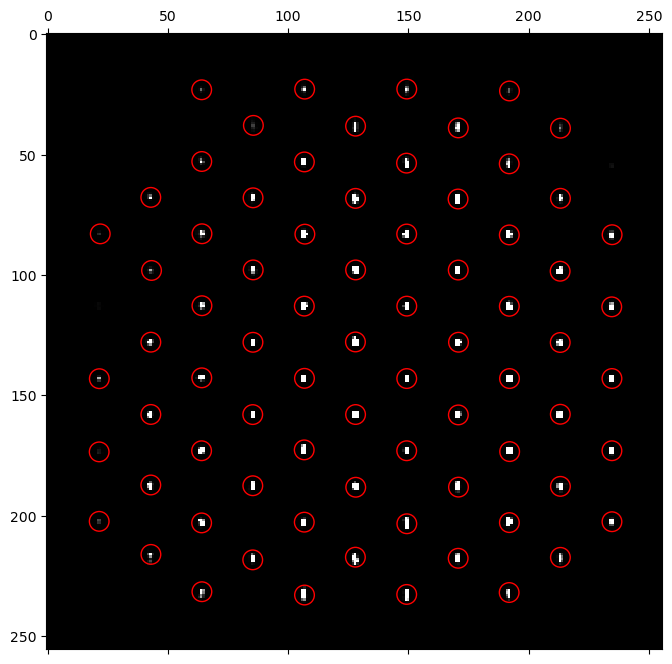

In [17]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=1, 
    edgeBoundary=10,
    minSpacing=10,
    minRelativeIntensity=0.0001,
    maxNumPeaks=100,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e-3,
    open_circles=True,
    scale=200)

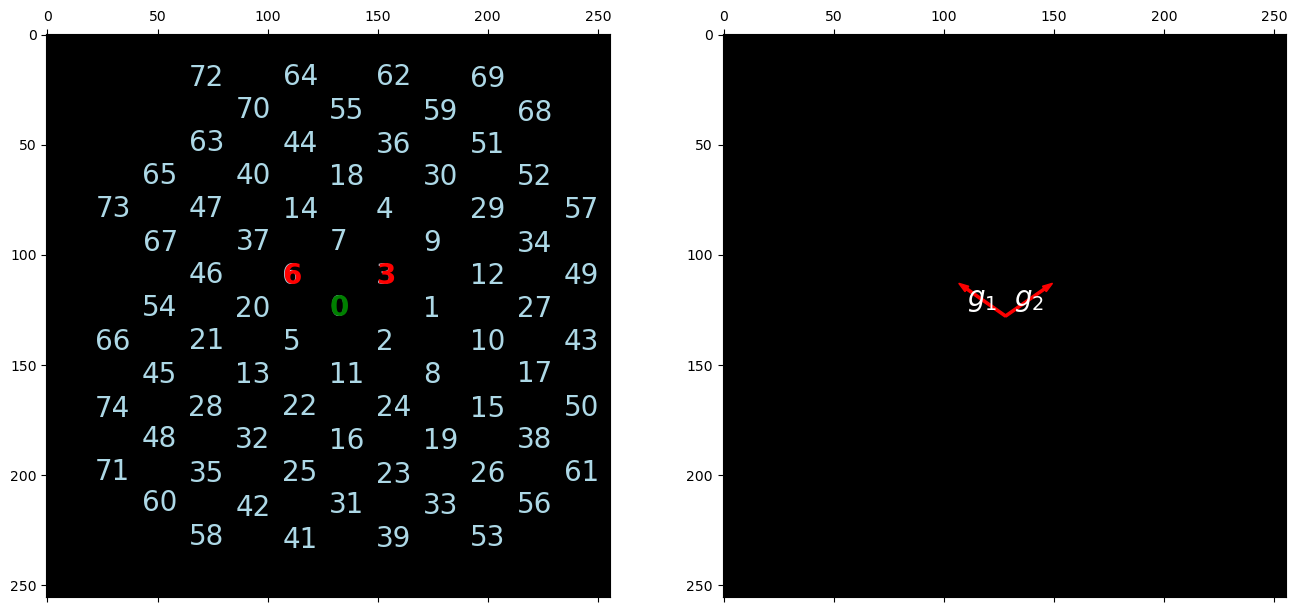

In [20]:
# Define peaks to use for computing strain maps
index_0, index_g1, index_g2 = 0, 6, 3

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=1e3,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

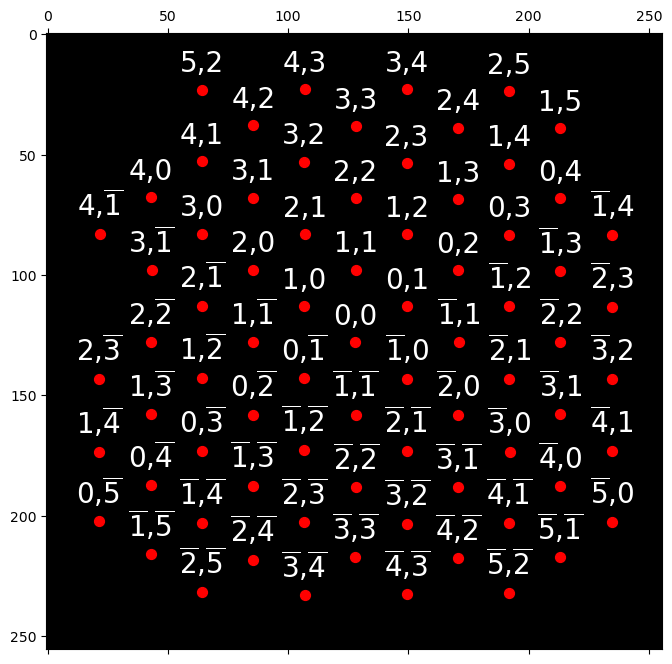

In [21]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0,qy0,
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e3,
    braggdirections=braggdirections,
    points=True)

In [22]:
# maximum peak spacing from expected positions - this helps prevent false positives from affecting the results.
max_peak_spacing = 4

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0,
    qy_shift=qy0)

In [23]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|██████████| 10050/10050 [00:02<00:00, 5003.28it/s]


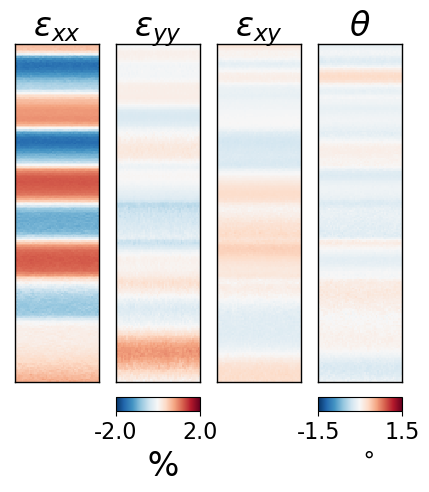

In [24]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset.R_Nx,dataset.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = np.add(g2, g1)
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

mask = strainmap_mediang1g2.slices['mask'] == 1
# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.5, 1.5],
    ticknumber=2,
    axes_plots=(),
    bkgrd=False,
    figsize=(5,10),
    layout=1,
    show_cbars=('eyy','theta'))

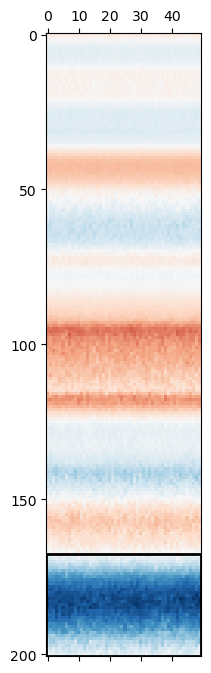

In [25]:
# Set the reference lattice to be the probe positions inside the substrate.

x0,xf = 168,201
y0,yf = 0,50

py4DSTEM.visualize.show(
    strainmap_mediang1g2.slices['e_yy'],              
    mask=mask,
    figsize=(2, 12),
    cmap='RdBu',
    clipvals='centered',
    min=0,
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

In [26]:
# Get new reference lattice vectors
mask = np.zeros((dataset.R_Nx,dataset.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

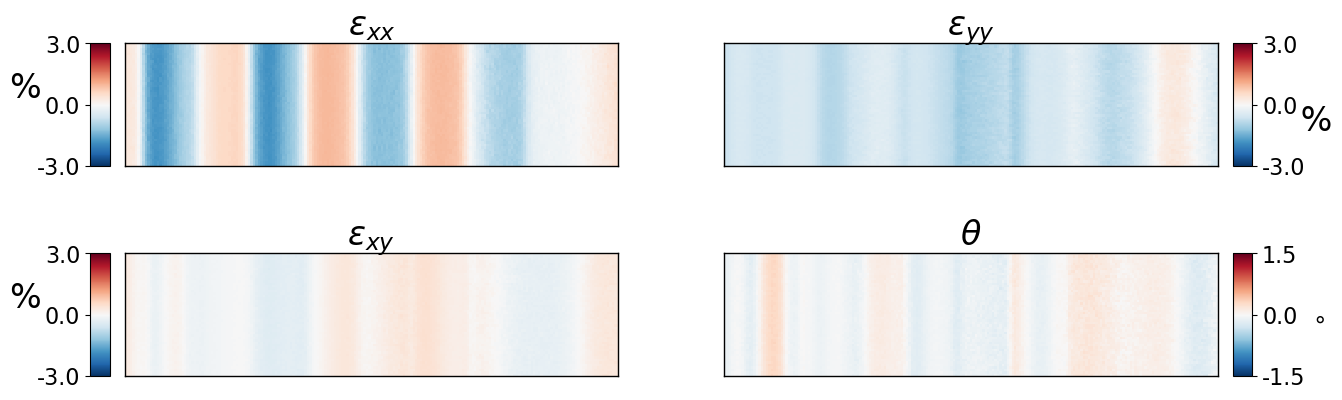

In [27]:
# Lets visualize the recalculated strain maps
strainmap_ROI_transpose = copy.deepcopy(strainmap_ROI)
strainmap_ROI_transpose.slices['e_xx'] = np.transpose(strainmap_ROI_transpose.slices['e_xx'])
strainmap_ROI_transpose.slices['e_yy'] = np.transpose(strainmap_ROI_transpose.slices['e_yy'])
strainmap_ROI_transpose.slices['e_xy'] = np.transpose(strainmap_ROI_transpose.slices['e_xy'])
strainmap_ROI_transpose.slices['theta'] = np.transpose(strainmap_ROI_transpose.slices['theta'])
strainmap_ROI_transpose.slices['mask'] = np.transpose(strainmap_ROI_transpose.slices['mask'])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI_transpose,
    vrange_exx=[-3.0, 3.0],
    vrange_theta=[-1.5, 1.5],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(15,5),
    returnfig=True)
#fig.savefig('./paper_figs/distort_strain.pdf', dpi=600)
plt.show()

# Plot line traces for the mean strain values

In [28]:
# Note to save time, we will just manually specify the probe positions
probe_step_x_ = np.arange(0,strainmap_ROI.data.shape[0]) * 4.033104 + 100.82759

In [30]:
import pandas as pd
strain_prof = pd.read_csv('./strain_profile_simulated.csv')
probe_step_x = strain_prof['position']
strain_ideal_e_xx =  strain_prof['strain']
strain_ideal_e_yy = np.zeros_like(probe_step_x)

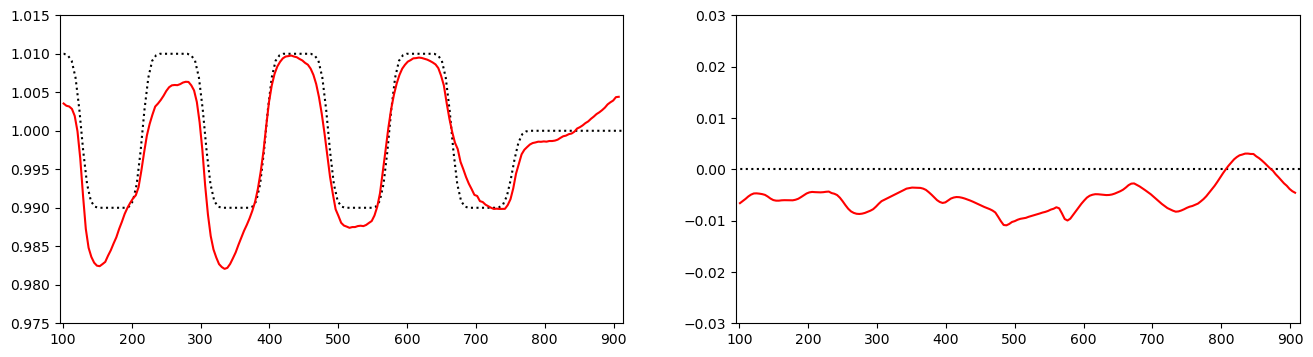

In [31]:
# Get mean E_xx and E_yy strain maps along the perpendicular to growth direction
strain_mean_e_xx = np.mean(strainmap_ROI.slices['e_xx'],axis=1)
strain_mean_e_yy = np.mean(strainmap_ROI.slices['e_yy'],axis=1)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(16,4))

# strain along x direction
axs[0].plot(
    probe_step_x, 
    strain_ideal_e_xx,
    color='k',
    linestyle=':');
axs[0].plot(
    probe_step_x_, 
    strain_mean_e_xx+1,
    color='r')
axs[0].set_xlim(95,914)
axs[0].set_ylim(0.975,1.015)

# strain along y direction
axs[1].plot(
    probe_step_x, 
    strain_ideal_e_yy,
    color='k',
    linestyle=':');
axs[1].plot(
    probe_step_x_, 
    strain_mean_e_yy,
    color='r')
axs[1].set_xlim(95,914)
axs[1].set_ylim(-0.03, 0.03)
plt.show()

# Save measured data, probes, virtual images, etc.

In [32]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe.data,
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output,[diff,
                                      real,
                                      probe_data,
                                      strainmap_ROI,
                                      bragg_peaks_centered],
                                      overwrite=True)

  6%|▋         | 630/10050 [00:00<00:01, 6295.70it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|██████████| 10050/10050 [00:01<00:00, 6242.14it/s]


In [33]:
# display the contents of the saved file
py4DSTEM.io.read(file_path_output)

py4DSTEM file version 0.12.8
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DiffractionSlice  (256, 256, 3)           diffraction_images                                    
  1       RealSlice         (201, 50, 2)            real_space_images                                     
  2       RealSlice         (201, 50, 5)            strain_map_rotated                                    
  3       PointList         (3, 1)                  probe_data                                            
  4       PointListArray    (201, 50, 3, -1)        braggpeaks_centered                                   
